# Hill Climbing

In [480]:
%matplotlib inline

import logging

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import cm
from tqdm.auto import tqdm
from typing import List, Dict, Tuple, Optional

logger = logging.getLogger('francium')

logging.basicConfig(
    format="%(asctime)s, %(name)s %(levelname)s %(message)s",
    level=logging.DEBUG
)

sns.set()

2020-12-02 21:55:49,925, matplotlib.pyplot DEBUG Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [468]:
class State:
    def __init__(self, init_state: Dict[str, float]):
        self.state_ : Dict[str, float] = init_state

    def __repr__(self):
        return str(self.state_)

    def __str__(self):
        return str(self.state_)

    def __getitem__(self, key) -> Dict[str, float]:
        return self.state_[key]

    def __setitem__(self, key, newval):
        self.state_[key] = newval

In [469]:
class Memory:
    def __init__(self, retain_mem: bool = True):
        self.retain_mem = retain_mem
        self.memory: List[State] = []
        self.best_episode = None

    def get_episode(self, episode: int) -> State:
        # return the state from `episode`
        return self.memory[episode]

    def add_episode(self, state: State) -> None:
        self.memory.append(state)

        if self.best_episode is None or state['z'] < self.best_episode['z']:
            self.best_episode = state

    def get_curr_state(self) -> State:
        # return from the latest state
        return self.memory[-1]

In [511]:
class Environment:
    def __init__(self, x_bounds: Tuple[float, float], y_bounds: Tuple[float, float], goal_val: Optional[State] = None, tolerance: Optional[float] = 1e-4):
        self.goal_val: State = goal_val
        self.tolerance: float = tolerance
        self.x_bounds: Tuple[float, float] = x_bounds
        self.y_bounds: Tuple[float, float] = y_bounds
    
    def get_random_init_position(self) -> State:
        x_min, x_max = self.x_bounds
        y_min, y_max = self.y_bounds

        init_state: State = State({
            'x': np.random.uniform(low = x_min, high = x_max),
            'y': np.random.uniform(low = y_min, high = y_max),
        })

        z, _ = self.evaluate_state(init_state)

        init_state['z'] = z
        
        return init_state

    def evaluation_func(self, X, Y):
        # return np.sin(np.sqrt(X ** 2 + Y ** 2) * 2)
        return 5 * np.sin(X**2 + Y**2) + (X**2 + Y**2)

    def evaluate_state(self, state: State) -> Tuple[float, bool]:
        eval_val = self.evaluation_func(state['x'], state['y'])

        if self.goal_val:
            is_done = True if np.abs(eval_val - goal_val['z']) < self.tolerance else False
        else:
            is_done = False
        
        return eval_val, is_done

In [512]:
class Agent:
    """The AI Agent"""
    def __init__(self, step_size: float = 1e-2):
        self.step_size = step_size

    def act(self, state: State, env: Environment):
        # get the current state, act upon it and give a new state
        new_state = State({
            'x': state['x'],
            'y': state['y']
        })
        new_state['x'] += np.random.randn() * self.step_size
        new_state['y'] += np.random.randn() * self.step_size

        # check if you are in bounds of the environment
        new_state['x'] = min(max(new_state['x'], env.x_bounds[0]), env.x_bounds[1])
        new_state['y'] = min(max(new_state['y'], env.y_bounds[0]), env.y_bounds[1])

        return new_state

    def __call__(self, *args, **kwargs) -> State:
        return self.act(*args, **kwargs)

In [513]:
class Solver:
    def __init__(self, agent: Agent, environment: Environment):
        self.agent: Agent = agent
        self.env: Environment = environment
        self.memory: Memory = Memory(retain_mem = True)
        self.initialized: bool = False

    def init_solver(self, init_state: Optional[State] = None):
        if init_state:
            self.memory.add_episode(init_state)
        else:
            init_state = self.env.get_random_init_position()

        logger.info(f"=> Initialized Solver with State: {init_state}")

        self.memory.add_episode(init_state)

        self.initialized = True

    def plot_history(self):

        x_min, x_max = self.env.x_bounds
        y_min, y_max = self.env.y_bounds

        x = np.linspace(x_min, x_max, 50)
        y = np.linspace(y_min, y_max, 50)

        X, Y = np.meshgrid(x, y)

        Z = self.env.evaluation_func(X, Y)
        
        fig = plt.figure(figsize=(15, 10))
        ax = plt.gca()
        cp = ax.contourf(X, Y, Z, 50, alpha = 0.6, cmap=cm.bwr)
        fig.colorbar(cp) # Add a colorbar to a plot
    
        x_states = [mem['x'] for mem in self.memory.memory]
        y_states = [mem['y'] for mem in self.memory.memory]

        ax.plot(x_states, y_states, color='black', marker='.', alpha=0.5, linewidth=1, markersize=1)
        ax.plot(x_states[0], y_states[0], color='red', marker='o')
        ax.plot(x_states[-1], y_states[-1], color='green', marker='o')
        
        plt.show()

    def train_step(self):

        if not self.initialized:
            logger.error("=> Solver not initialized !")
            raise Exception("Initialize the solver `solver.init_solver()`")

        curr_state = self.memory.get_curr_state()

        new_state = self.agent(curr_state, self.env)

        eval_val, is_done = self.env.evaluate_state(new_state)

        if is_done:
            logger.info(f"=> training is done ! best state: {self.memory.get_curr_state()}")
            return False

        if eval_val < curr_state['z']:
            # logger.info(f"z: f(x = {new_state['x']}, y = {new_state['y']}) = {eval_val}")
            new_state['z'] = eval_val
            self.memory.add_episode(new_state)

        return True

In [514]:
class SimulatedAnnealing:
    def __init__(
            self, 
            agent: Agent, 
            environment: Environment, 
            initial_temp: float, 
            final_temp: float, 
            iters_per_temp: int = 100, 
            temp_reduction: Optional[str] = None, 
            alpha: float = 10.0, 
            beta: float = 5.0
        ):

        self.agent: Agent = agent
        self.env: Environment = environment
        self.memory: Memory = Memory(retain_mem = True)
        self.initialized: bool = False
        self.curr_temp = initial_temp
        self.final_temp = final_temp
        self.iters_per_temp = iters_per_temp
        self.alpha = alpha
        self.beta = beta

        if temp_reduction == "linear":
            self.temp_decrement = self.linear_temp_reduction
        elif temp_reduction == "geometric":
            self.temp_decrement = self.geometric_temp_reduction
        elif temp_reduction == "slow_decrease":
            self.temp_decrement = self.slow_decrease_temp_reduction
        else:
            logger.info("=> Using linear_temp_reduction")
            self.temp_decrement = self.linear_temp_reduction

    def linear_temp_reduction(self):
        self.curr_temp -= self.alpha

    def geometric_temp_reduction(self):
        self.curr_temp *= (1 / self.alpha)

    def slow_decrease_temp_reduction(self):
        self.curr_temp = self.curr_temp / ( 1 + self.beta * self.curr_temp)

    def init_solver(self, init_state: Optional[State] = None):
        if init_state:
            self.memory.add_episode(init_state)
        else:
            init_state = self.env.get_random_init_position()

        logger.info(f"=> Initialized Solver with State: {init_state}")

        self.memory.add_episode(init_state)

        self.initialized = True

    def plot_history(self):
        x_min, x_max = self.env.x_bounds
        y_min, y_max = self.env.y_bounds

        x = np.linspace(x_min, x_max, 50)
        y = np.linspace(y_min, y_max, 50)

        X, Y = np.meshgrid(x, y)

        Z = self.env.evaluation_func(X, Y)

        fig = plt.figure(figsize=(15, 10))
        ax = plt.gca()
        cp = ax.contourf(X, Y, Z, 50, alpha = 0.6, cmap=cm.bwr)
        fig.colorbar(cp) # Add a colorbar to a plot
    
        x_states = [mem['x'] for mem in self.memory.memory]
        y_states = [mem['y'] for mem in self.memory.memory]

        ax.plot(x_states, y_states, color='black', marker='.', alpha=0.5, linewidth=1, markersize=1)
        ax.plot(x_states[0], y_states[0], color='red', marker='o')
        ax.plot(x_states[-1], y_states[-1], color='green', marker='o')
        
        plt.show()

    def train_step(self) -> bool:

        if not self.initialized:
            logger.error("=> Solver not initialized !")
            raise Exception("Initialize the solver `solver.init_solver()`")

        for iter in range(self.iters_per_temp):

            if self.curr_temp <= self.final_temp:
                logger.warning(f"=> curr_temp {self.curr_temp} <= final_temp {self.final_temp} ! cannot anneal further")
                return False

            curr_state: State = self.memory.get_curr_state()

            new_state: State = self.agent(curr_state, self.env)

            eval_val, is_done = self.env.evaluate_state(new_state)

            if is_done:
                logger.info(f"=> training is done ! best state: {self.memory.get_curr_state()}")
                return False

            cost: float = curr_state['z'] - eval_val

            # check if we can update state based on annealing temp.
            can_anneal: bool = np.random.uniform(0, 1) < np.exp(cost / self.curr_temp)

            if cost >= 0 or can_anneal:
                # logger.info(f"z: f(x = {new_state['x']}, y = {new_state['y']}) = {eval_val}")
                new_state['z'] = eval_val

                self.memory.add_episode(new_state)
        
        # reduce the temperature
        self.temp_decrement()

        return True

In [524]:
agent = Agent(step_size=1e-1)
env = Environment(x_bounds=(-5.0, 5.0), y_bounds=(-5.0, 5.0))
solver = Solver(agent=agent, environment=env)

In [525]:
solver.init_solver(
    init_state=State({
        'x': 4.0,
        'y': 2.0,
        'z': env.evaluation_func(4.0, 2.0)
    })
)
for episode in tqdm(range(1000)):
    trainable = solver.train_step()
    if not trainable:
        break

2020-12-02 22:03:26,698, francium INFO => Initialized Solver with State: {'x': 4.0, 'y': 2.0, 'z': 24.56472625363814}


In [526]:
solver.memory.best_episode

{'x': 3.7264265431440777, 'y': 1.786244408629875, 'z': 12.178422747581994}

2020-12-02 22:03:27,502, matplotlib.colorbar DEBUG locator: <matplotlib.ticker.FixedLocator object at 0x7fc591acf1d0>
2020-12-02 22:03:27,503, matplotlib.colorbar DEBUG Using fixed locator on colorbar
2020-12-02 22:03:27,515, matplotlib.colorbar DEBUG Setting pcolormesh


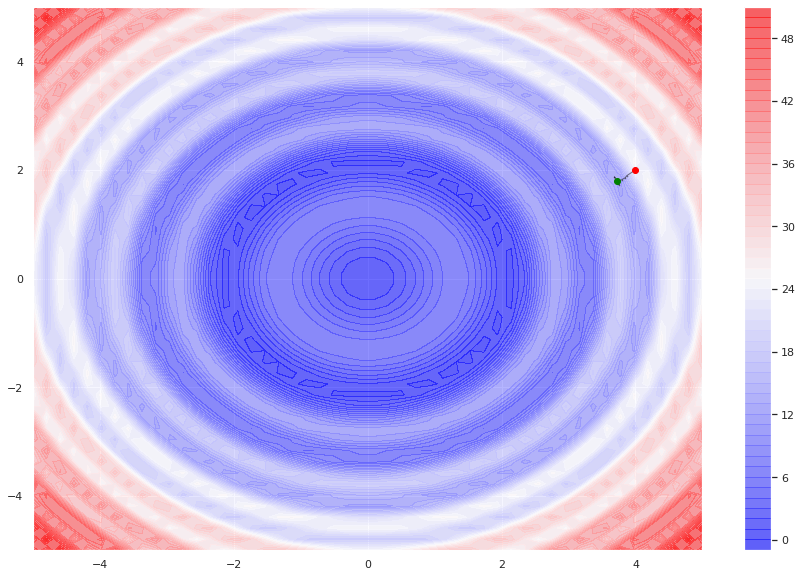

In [527]:
solver.plot_history()

In [528]:
agent = Agent(step_size=1e-1)
env = Environment(x_bounds=(-5.0, 5.0), y_bounds=(-5.0, 5.0))
solver = SimulatedAnnealing(agent=agent, environment=env, initial_temp=100.0, final_temp=0.0, iters_per_temp=100, temp_reduction="linear")

In [529]:
solver.init_solver(
    init_state=State({
        'x': 4.0,
        'y': 2.0,
        'z': env.evaluation_func(4.0, 2.0)
    })
)
for episode in tqdm(range(10)):
    trainable = solver.train_step()
    if not trainable:
        break

2020-12-02 22:03:31,438, francium INFO => Initialized Solver with State: {'x': 4.0, 'y': 2.0, 'z': 24.56472625363814}


In [530]:
solver.memory.best_episode

{'x': -0.6315378135958896, 'y': 2.0253980559340325, 'z': -0.3877059031921135}

2020-12-02 22:03:36,378, matplotlib.colorbar DEBUG locator: <matplotlib.ticker.FixedLocator object at 0x7fc59111a358>
2020-12-02 22:03:36,379, matplotlib.colorbar DEBUG Using fixed locator on colorbar
2020-12-02 22:03:36,391, matplotlib.colorbar DEBUG Setting pcolormesh


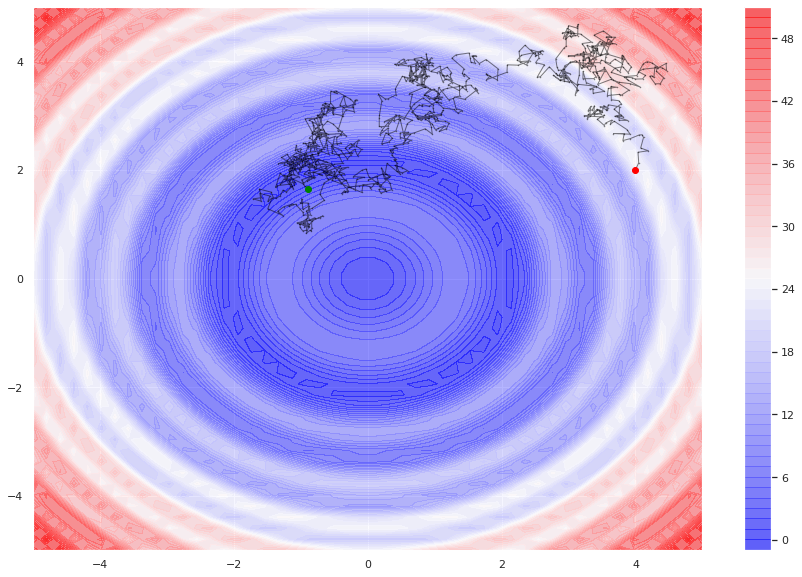

In [531]:
solver.plot_history()

2020-12-02 22:03:43,435, matplotlib.axes._base DEBUG not adjusting title pos because a title was already placed manually: 0.920000
2020-12-02 22:03:43,437, matplotlib.axes._base DEBUG title position was updated manually, not adjusting
2020-12-02 22:03:43,438, matplotlib.axes._base DEBUG title position was updated manually, not adjusting
2020-12-02 22:03:43,447, matplotlib.axes._base DEBUG title position was updated manually, not adjusting
2020-12-02 22:03:43,448, matplotlib.axes._base DEBUG title position was updated manually, not adjusting
2020-12-02 22:03:43,556, matplotlib.axes._base DEBUG title position was updated manually, not adjusting


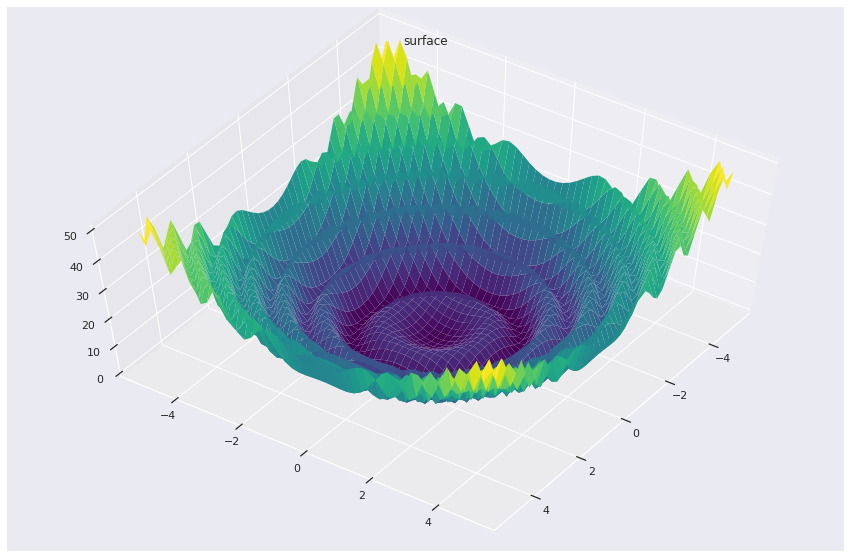

In [532]:
x_min, x_max = (-5, 5)
y_min, y_max = (-5, 5)

x = np.linspace(x_min, x_max, 50)
y = np.linspace(y_min, y_max, 50)

X, Y = np.meshgrid(x, y)

Z = solver.env.evaluation_func(X, Y)
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
               cmap="viridis", edgecolor='none')
ax.set_title('surface')
ax.view_init(60, 35)
plt.show()

2020-12-02 21:33:36,677, matplotlib.colorbar DEBUG locator: <matplotlib.ticker.FixedLocator object at 0x7fc592de3940>
2020-12-02 21:33:36,678, matplotlib.colorbar DEBUG Using fixed locator on colorbar
2020-12-02 21:33:36,690, matplotlib.colorbar DEBUG Setting pcolormesh


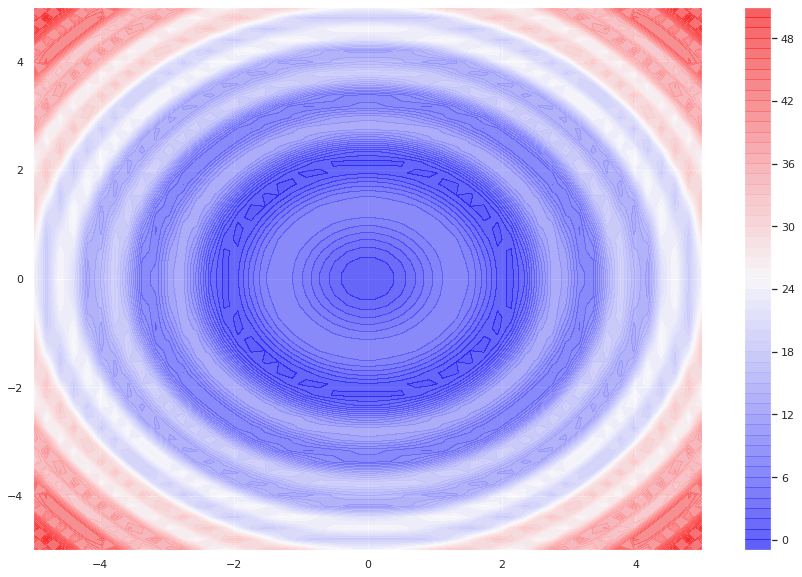

In [454]:
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()
cp = ax.contourf(X, Y, Z, 50, alpha = 0.6, cmap=cm.bwr)
fig.colorbar(cp) # Add a colorbar to a plot
plt.show()

2020-12-02 21:31:05,921, matplotlib.axes._base DEBUG not adjusting title pos because a title was already placed manually: 0.920000
2020-12-02 21:31:05,924, matplotlib.axes._base DEBUG title position was updated manually, not adjusting
2020-12-02 21:31:05,929, matplotlib.axes._base DEBUG title position was updated manually, not adjusting
2020-12-02 21:31:05,933, matplotlib.axes._base DEBUG title position was updated manually, not adjusting
2020-12-02 21:31:05,934, matplotlib.axes._base DEBUG title position was updated manually, not adjusting
2020-12-02 21:31:06,046, matplotlib.axes._base DEBUG title position was updated manually, not adjusting


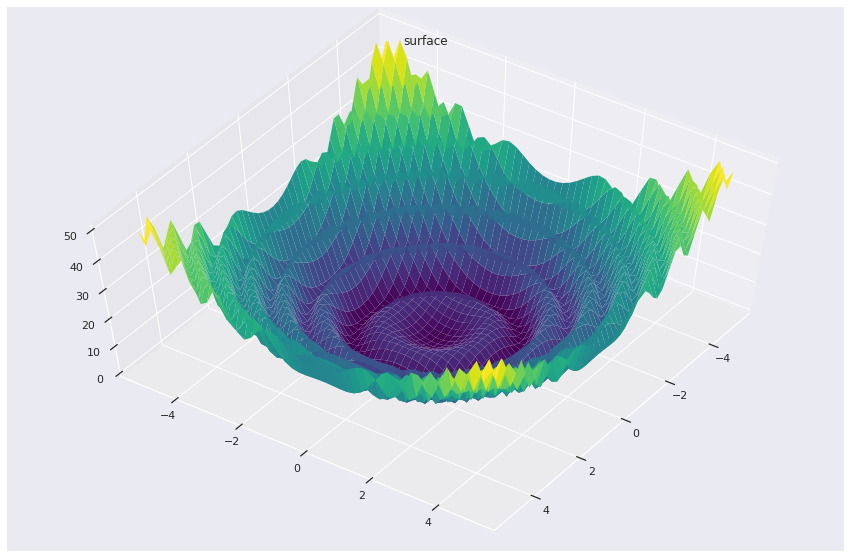

In [423]:
x_min, x_max = (-5, 5)
y_min, y_max = (-5, 5)

x = np.linspace(x_min, x_max, 50)
y = np.linspace(y_min, y_max, 50)

X, Y = np.meshgrid(x, y)

Z = 5 * np.sin(X**2 + Y**2) + (X**2 + Y**2)
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
               cmap="viridis", edgecolor='none')
ax.set_title('surface')
ax.view_init(60, 35)
plt.show()

2020-12-02 21:31:11,796, matplotlib.colorbar DEBUG locator: <matplotlib.ticker.FixedLocator object at 0x7fc590e2b4a8>
2020-12-02 21:31:11,797, matplotlib.colorbar DEBUG Using fixed locator on colorbar
2020-12-02 21:31:11,812, matplotlib.colorbar DEBUG Setting pcolormesh


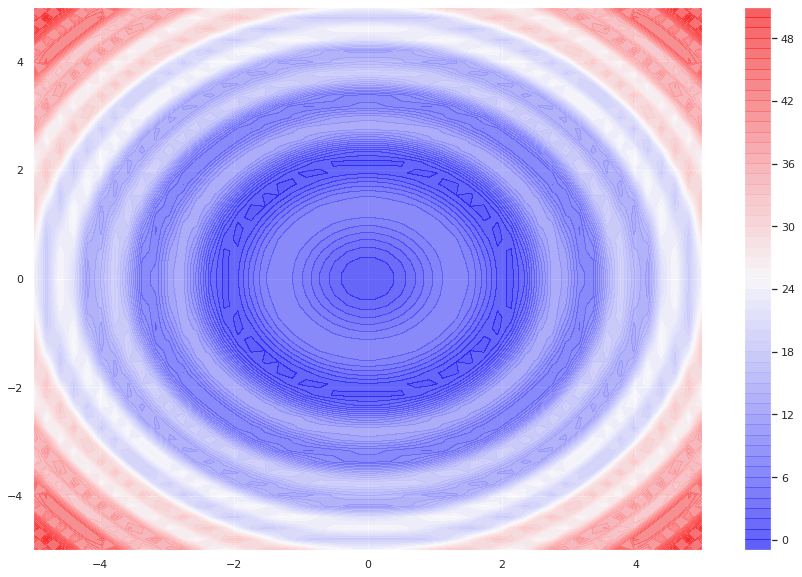

In [424]:
fig = plt.figure(figsize=(15, 10))
ax = plt.gca()
cp = ax.contourf(X, Y, Z, 50, alpha = 0.6, cmap=cm.bwr)
fig.colorbar(cp) # Add a colorbar to a plot
plt.show()